In [1]:
from ml_model.data import get_data
from sklearn import set_config; set_config(display='diagram')
import pandas as pd
%load_ext autoreload
%autoreload 2

In [3]:
fname = './ml_model/data/database_with_artifical_values.csv'

X_train, X_test, y_train, y_test = get_data()

FileNotFoundError: [Errno 2] No such file or directory: '../ml_model/data/database_with_artifical_values.csv'

In [3]:
X_train

,Project Id,Armour Type,Armour Slope [v:h],Armour Density [kg/m3],Armour Mass [kg],Water Density [kg/m3],Offshore Significant Wave Height [m],Offshore Bed Elevation [m Datum],Average slope between offshore wave location and in front of Section [v:h],Significant Wave Height at Toe [m],Bed Elevation at Toe [m Datum],Peak Wave Period [s],Number of Waves [-],Crest Level [m Datum],Water Level [ m Datum],Notional Permeability [-]
Id,,,,,,,,,,,,,,,,
475,10,ROCK,1:06,2682.6,0.125159,1020,0.193000,-0.800000,1:1000,0.193000,-0.800000,1.830000,1000,10.000000,0.0,0.1
2872,10,ROCK,1:04,2667.3,646.292776,1020,2.348243,-13.853940,1:1000,2.348243,-13.853940,8.073157,1000,173.174248,0.0,0.1
6494,-1,XBLOCK,3:04,2500.0,68.281673,1030,1.500000,-50.000000,1:1000,0.750000,-25.000000,10.000000,1000,10.000000,0.0,0.1
6170,-1,XBLOCK,3:04,2400.0,41148.692100,1030,7.000000,-50.000000,1:1000,17.500000,-36.000000,10.000000,1000,10.000000,0.0,0.1
5603,-1,XBLOCK,3:04,2350.0,19147.671510,1030,9.000000,-50.000000,1:1000,4.500000,-23.000000,8.000000,1000,10.000000,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,10,ROCK,1:06,2682.6,0.125159,1020,0.201700,-0.800000,1:1000,0.201700,-0.800000,3.170000,3000,10.000000,0.0,0.1
1076,10,ROCK,1:03,2682.6,22.000000,1020,0.779196,-4.481359,1:1000,0.779196,-4.481359,3.313507,1000,56.016988,0.0,0.1
4078,10,ROCK,01:01.5,2667.3,4474.334601,1020,2.782343,-26.404200,1:1000,2.782343,-26.404200,11.260238,3000,330.052503,0.0,0.5


In [4]:
X_train.columns

Index(['Project Id', 'Armour Type', 'Armour Slope [v:h]',
       'Armour Density [kg/m3]', 'Armour Mass [kg]', 'Water Density [kg/m3]',
       'Offshore Significant Wave Height [m]',
       'Offshore Bed Elevation [m Datum]',
       'Average slope between offshore wave location and in front of Section [v:h]',
       'Significant Wave Height at Toe [m]', 'Bed Elevation at Toe [m Datum]',
       'Peak Wave Period [s]', 'Number of Waves [-]', 'Crest Level [m Datum]',
       'Water Level [ m Datum]', 'Notional Permeability [-]'],
      dtype='object')

In [5]:
X_train['Armour Slope [v:h]']

Id
475        1:06
2872       1:04
6494       3:04
6170       3:04
5603       3:04
         ...   
701        1:06
1076       1:03
4078    01:01.5
5671       3:04
620        1:03
Name: Armour Slope [v:h], Length: 4944, dtype: object

In [6]:
X_train['Armour Slope [v:h]'].apply(lambda row: float(row.split(':')[1]) / float(row.split(':')[0]))

Id
475     6.000000
2872    4.000000
6494    1.333333
6170    1.333333
5603    1.333333
          ...   
701     6.000000
1076    3.000000
4078    1.500000
5671    1.333333
620     3.000000
Name: Armour Slope [v:h], Length: 4944, dtype: float64

In [7]:
#ohe armor type
#convert slope to cotangent
#relative density
#depth at toe
#structure height
ohe_columns = 'Armour Type'

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor


def convert_to_coteng(df):
    return pd.DataFrame(df['Armour Slope [v:h]'].apply(lambda row: float(row.split(':')[1]) / float(row.split(':')[0])))

num_transformer = Pipeline([
    ('scaler', RobustScaler())])

coteng_slope = FunctionTransformer(convert_to_coteng)
depth_toe = FunctionTransformer(lambda df: pd.DataFrame(df['Water Level [ m Datum]'] - df['Bed Elevation at Toe [m Datum]']))
structure_height = FunctionTransformer(lambda df: pd.DataFrame(df['Crest Level [m Datum]'] - df['Bed Elevation at Toe [m Datum]']))
relative_density = FunctionTransformer(lambda df: pd.DataFrame((df['Armour Density [kg/m3]'] - df['Water Density [kg/m3]']) / df['Water Density [kg/m3]']))

union_custom_transformer = FeatureUnion([
    ('coteng', coteng_slope),
    ('depth_toe', depth_toe),
    ('structure_height', structure_height),
    ('relative_density', relative_density)
])
    


custom_transformer = Pipeline([('union_custom_transformer',union_custom_transformer), 
          ('scaler_custom',RobustScaler())])
    


# # Encode categorical variables
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# # Paralellize "num_transformer" and "One hot encoder"
preprocessor = ColumnTransformer([
    ('num_tr', num_transformer, ['Armour Mass [kg]','Significant Wave Height at Toe [m]','Peak Wave Period [s]','Number of Waves [-]','Notional Permeability [-]']),
    ('cat_tr', cat_transformer, ['Armour Type']),
])

#union

preproc = FeatureUnion([
    ('preprocess', preprocessor), # columns 0-8
    ('custom_tr', custom_transformer) # new colums 9
])
preproc

FeatureUnion(transformer_list=[('preprocess',
                                ColumnTransformer(transformers=[('num_tr',
                                                                 Pipeline(steps=[('scaler',
                                                                                  RobustScaler())]),
                                                                 ['Armour Mass '
                                                                  '[kg]',
                                                                  'Significant '
                                                                  'Wave Height '
                                                                  'at Toe [m]',
                                                                  'Peak Wave '
                                                                  'Period [s]',
                                                                  'Number of '
                                                                  'Waves [-]',
                                                                  'Notional '
                                                                  'Permeability '
                                                                  '[-]']),
                                                                ('cat_tr',
                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                 ['Armour '
                                                                  'Type'])])),
                               ('custom_tr',
                                Pipel...
                                                                                 FunctionTransformer(func=<function convert_to_coteng at 0x7f522013eb80>)),
                                                                                ('depth_toe',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x7f522015c310>)),
                                                                                ('structure_height',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x7f521fa12280>)),
                                                                                ('relative_density',
                                                                                 FunctionTransformer(func=<function <lambda> at 0x7f521f984790>))])),
                                                ('scaler_custom',
                                                 RobustScaler())]))])

In [9]:
# Add Estimator
pipe = make_pipeline(preproc, RandomForestRegressor())
pipe.fit(X_train,y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('num_tr',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['Armour '
                                                                                   'Mass '
                                                                                   '[kg]',
                                                                                   'Significant '
                                                                                   'Wave '
                                                                                   'Height '
                                                                                   'at '
                                                                                   'Toe '
                                                                                   '[m]',
                                                                                   'Peak '
                                                                                   'Wave '
                                                                                   'Period '
                                                                                   '[s]',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'Waves '
                                                                                   '[-]',
                                                                                   'Notional '
                                                                                   'Permeability '
                                                                                   '[-]']),
                                                                                 ('cat_tr',
                                                                                  OneHotEncoder(handle_unknown='...
                                                                                                  FunctionTransformer(func=<function convert_to_coteng at 0x7f522013eb80>)),
                                                                                                 ('depth_toe',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f522015c310>)),
                                                                                                 ('structure_height',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f521fa12280>)),
                                                                                                 ('relative_density',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f521f984790>))])),
                                                                 ('scaler_custom',
                                                                  RobustScaler())]))])),
                ('randomforestregressor', RandomForestRegressor())])

In [14]:
from sklearn.model_selection import GridSearchCV

params = {'randomforestregressor__n_estimators': [150,200,250,300],
              'randomforestregressor__max_depth':[7,8,9,10]}

# Instanciate Grid Search
search = GridSearchCV(pipe, 
                      param_grid=params, 
                      scoring = 'neg_root_mean_squared_error',
                      cv = 5,
                      verbose = 2) 

# Fit data to Grid Search
search.fit(X_train,y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=150; total time=   0.7s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=150; total time=   0.7s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=150; total time=   0.7s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=150; total time=   0.7s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=150; total time=   0.7s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=200; total time=   0.9s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=200; total time=   0.9s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=200; total time=   0.9s
[CV] END randomforestregressor__max_depth=7, randomforestregressor__n_estimators=200; total time=  

[CV] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=300; total time=   1.8s
[CV] END randomforestregressor__max_depth=10, randomforestregressor__n_estimators=300; total time=   1.8s


In [15]:
#search.get_params().keys()

In [16]:
search.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 300}

In [17]:
from sklearn.model_selection import cross_val_score

# Cross validate pipeline
cross_val_score(search.best_estimator_, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

-4.1692550112931235

4.337806332730922


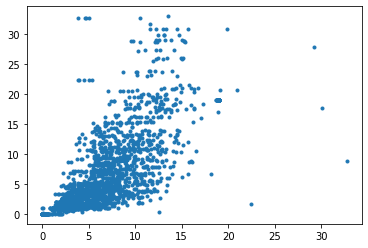

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred = search.best_estimator_.predict(X_test)
plt.plot(y_pred,y_test, marker = '.', linewidth = 0)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [24]:
# Train pipeline
pipe.fit(X_train,y_train)


Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('num_tr',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['Armour '
                                                                                   'Mass '
                                                                                   '[kg]',
                                                                                   'Significant '
                                                                                   'Wave '
                                                                                   'Height '
                                                                                   'at '
                                                                                   'Toe '
                                                                                   '[m]',
                                                                                   'Peak '
                                                                                   'Wave '
                                                                                   'Period '
                                                                                   '[s]',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'Waves '
                                                                                   '[-]',
                                                                                   'Notional '
                                                                                   'Permeability '
                                                                                   '[-]']),
                                                                                 ('cat_tr',
                                                                                  OneHotEncoder(handle_unknown='...
                                                                                                  FunctionTransformer(func=<function convert_to_coteng at 0x7f522013eb80>)),
                                                                                                 ('depth_toe',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f522015c310>)),
                                                                                                 ('structure_height',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f521fa12280>)),
                                                                                                 ('relative_density',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f521f984790>))])),
                                                                 ('scaler_custom',
                                                                  RobustScaler())]))])),
                ('randomforestregressor', RandomForestRegressor())])

3.2818057708138135


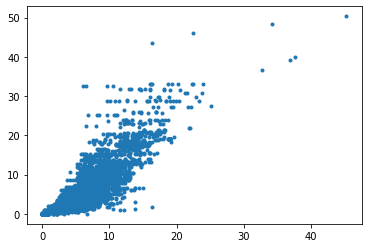

In [27]:
y_pred_train = search.best_estimator_.predict(X_train)
plt.plot(y_pred_train,y_train, marker = '.', linewidth = 0)

print(np.sqrt(mean_squared_error(y_train, y_pred_train)))

In [26]:
pipe.score(X_train,y_train)

0.9391286166139043

In [28]:
from sklearn.model_selection import cross_val_score

cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

-3.938059126212771

In [29]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

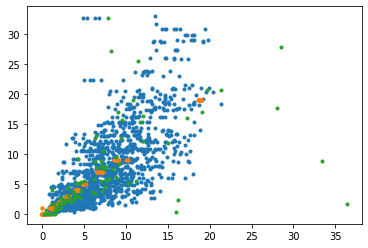

In [30]:
mask1 = X_test['Armour Type'] == 'ROCK'
mask2 = X_test['Armour Type'] == 'XBLOCK'
mask3 = X_test['Armour Type'] == 'HANBAR'

plt.plot(pipe.predict(X_test[mask1]),y_test[mask1], marker = '.', linewidth = 0)
plt.plot(pipe.predict(X_test[mask2]),y_test[mask2], marker = '.', linewidth = 0)
plt.plot(pipe.predict(X_test[mask3]),y_test[mask3], marker = '.', linewidth = 0)

In [31]:
X_test['Armour Type'].unique()

array(['ROCK', 'XBLOCK', 'HANBAR'], dtype=object)

In [57]:
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adagrad',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(32,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dense(16,activation='relu',kernel_initializer=kernel_initializer))
    model.add(Dense(1,activation='relu',kernel_initializer=kernel_initializer))

    model.compile(loss='mse',optimizer=optimizer, metrics=[keras.metrics.MeanSquaredError(name="mean_squared_error", dtype=None)])

    return model

# wrap the model using the function you created
clf = KerasRegressor(build_fn=create_model,verbose=0)



param_grid = {
    'clf__optimizer':['adam'],
    'clf__epochs':[200,250,300],
    'clf__dropout':[0.12,0.15,0.18],
    'clf__kernel_initializer':['glorot_uniform']
}

pipeline = Pipeline([
    ('preprocess',preproc),
    ('clf',clf)
])



/tmp/ipykernel_3378/3537403322.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  clf = KerasRegressor(build_fn=create_model,verbose=0)


In [58]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(transformers=[('num_tr',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   RobustScaler())]),
                                                                                  ['Armour '
                                                                                   'Mass '
                                                                                   '[kg]',
                                                                                   'Significant '
                                                                                   'Wave '
                                                                                   'Height '
                                                                                   'at '
                                                                                   'Toe '
                                                                                   '[m]',
                                                                                   'Peak '
                                                                                   'Wave '
                                                                                   'Period '
                                                                                   '[s]',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'Waves '
                                                                                   '[-]',
                                                                                   'Notional '
                                                                                   'Permeability '
                                                                                   '[-]']),
                                                                                 ('cat_tr',
                                                                                  OneHotEncoder(handle_unknown='ig...
                                                                                                 ('depth_toe',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f522015c310>)),
                                                                                                 ('structure_height',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f521fa12280>)),
                                                                                                 ('relative_density',
                                                                                                  FunctionTransformer(func=<function <lambda> at 0x7f521f984790>))])),
                                                                 ('scaler_custom',
                                                                  RobustScaler())]))])),
                ('clf',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f516744a520>)])

In [59]:
# if you're not using a GPU, you can set n_jobs to something other than 1
grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid, verbose = 2)
grid.fit(X_train, y_train)

# summaraize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END clf__dropout=0.12, clf__epochs=200, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  20.4s
[CV] END clf__dropout=0.12, clf__epochs=200, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  20.3s
[CV] END clf__dropout=0.12, clf__epochs=200, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  20.8s
[CV] END clf__dropout=0.12, clf__epochs=200, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  21.3s
[CV] END clf__dropout=0.12, clf__epochs=200, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  20.2s
[CV] END clf__dropout=0.12, clf__epochs=250, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  25.7s
[CV] END clf__dropout=0.12, clf__epochs=250, clf__kernel_initializer=glorot_uniform, clf__optimizer=adam; total time=  25.2s
[CV] END clf__dropout=0.12, clf__epochs=250, clf__kernel_initiali

In [60]:
grid.predict(X_test)

array([ 2.191262  ,  7.0533614 , 11.530787  , ...,  0.19418392,
        5.249152  ,  2.5468755 ], dtype=float32)

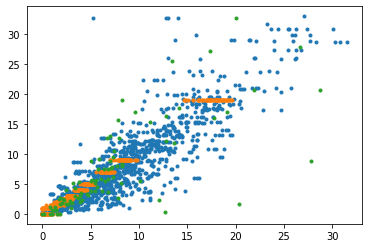

In [61]:
mask1 = X_test['Armour Type'] == 'ROCK'
mask2 = X_test['Armour Type'] == 'XBLOCK'
mask3 = X_test['Armour Type'] == 'HANBAR'

plt.plot(grid.predict(X_test[mask1]),y_test[mask1], marker = '.', linewidth = 0)
plt.plot(grid.predict(X_test[mask2]),y_test[mask2], marker = '.', linewidth = 0)
plt.plot(grid.predict(X_test[mask3]),y_test[mask3], marker = '.', linewidth = 0)

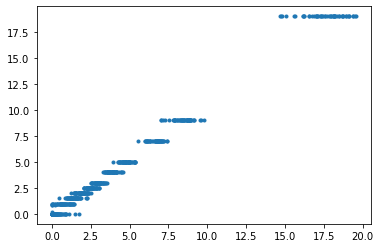

In [62]:
plt.plot(grid.predict(X_test[mask2]),y_test[mask2], marker = '.', linewidth = 0)

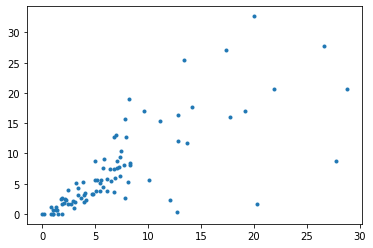

In [63]:
plt.plot(grid.predict(X_test[mask3]),y_test[mask3], marker = '.', linewidth = 0)

In [64]:
grid.best_params_

{'clf__dropout': 0.12,
 'clf__epochs': 250,
 'clf__kernel_initializer': 'glorot_uniform',
 'clf__optimizer': 'adam'}

In [65]:
y_pred = grid.best_estimator_.predict(X_test)

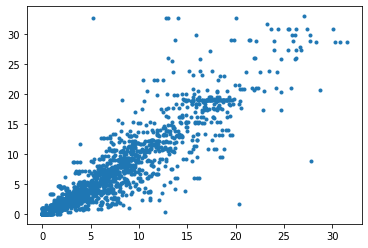

In [66]:
plt.plot(y_pred,y_test, marker = '.', linewidth = 0)

2.6601712953855876


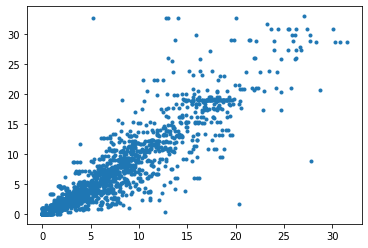

In [67]:
y_pred = grid.best_estimator_.predict(X_test)
plt.plot(y_pred,y_test, marker = '.', linewidth = 0)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

In [69]:
print(np.sqrt(mean_squared_error(y_test[mask1], y_pred[mask1])))

3.0387842058756362


In [70]:
print(np.sqrt(mean_squared_error(y_test[mask2], y_pred[mask2])))

0.6819183811635607


In [71]:
print(np.sqrt(mean_squared_error(y_test[mask3], y_pred[mask3])))

4.772586072701925
